In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord
from inverse_covariance import QuicGraphicalLasso
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri

# utils
import sys
sys.path.append('../utils')
from utils import standardize, mcc, pseudo_BIC, gauss_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

In [2]:
graph_structures = ['hub_network', 'erdos_renyi']

### Generate graph and data

In [3]:
n, p = 500, 1000
n_prop_to_p = [0.5]
random_state = 2023
lower_weight, upper_weight = 0.5, 1.0

# generate hub network and data
Skel = np.genfromtxt('../data/hub_network_structure.txt', delimiter=',')

# projection method
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Theta = np.multiply(edge_weights, edge_signs)
Theta = np.multiply(Skel, Theta)
Theta = np.tril(Theta) + np.tril(Theta).T
nz_indx = np.nonzero(Theta)
for i in range(100):
    Theta = proj_precision_mat(Theta, nz_indx)
    if np.linalg.cond(Theta) < 20:
        break

Theta = np.real(Theta)
# spread diagonal of precision matrix
spread_diag=[1, 3]
d = np.random.uniform(spread_diag[0], spread_diag[1], p)
Theta_hub = np.diag(d) @ Theta @ np.diag(d)
Sigma_hub = np.linalg.inv(Theta_hub)

Xs = generate_data(p, n_prop_to_p, Sigma_hub, N=1, standard=True, random_state=2023)
X_hub = Xs[0]

# generate erdos renyi graph and data
Theta_er, Sigma_er = generate_erdos_renyi(p, type='proj', edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, 3], random_state=2023)

Xs = generate_data(p, n_prop_to_p, Sigma_er, N=1, standard=True, random_state=2023)
X_er = Xs[0]

In [4]:
# get lambda ranges for each graph
S = np.matmul(X_hub.T, X_hub)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
lams_hub = lams[::-1][15:27]

S = np.matmul(X_er.T, X_er)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
lams_er = lams[::-1][8:20]

### Run ACCORD

In [5]:
accord_edges_hub, accord_mccs_hub = [], []
accord_edges_er, accord_mccs_er = [], []

accord_pbics_hub, accord_epbics_hub, accord_gbics_hub = [], [], []
accord_pbics_er, accord_epbics_er, accord_gbics_er = [], [], []

for graph_structure in graph_structures:
    random_state = 2023
    np.random.seed(random_state)
    if graph_structure == 'hub_network':
        for lam in lams_hub:
            model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=100)
            model.fit(X_hub)
            Omega_hat = model.omega_.toarray()
            Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
            
            accord_pbics_hub.append(pseudo_BIC(X_hub, Theta_hat, modified=False))
            accord_epbics_hub.append(pseudo_BIC(X_hub, Theta_hat, modified=True, gamma=0.2))
            accord_gbics_hub.append(gauss_BIC(X_hub, Theta_hat))
            
            accord_edges_hub.append((len(np.flatnonzero(Theta_hat))-p)/2)
            accord_mccs_hub.append(mcc(Theta_hub, Theta_hat))
            
    elif graph_structure == 'erdos_renyi':
        for lam in lams_er:
            model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=100)
            model.fit(X_er)
            Omega_hat = model.omega_.toarray()
            Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
            
            accord_pbics_er.append(pseudo_BIC(X_er, Theta_hat, modified=False))
            accord_epbics_er.append(pseudo_BIC(X_er, Theta_hat, modified=True, gamma=0.2))
            accord_gbics_er.append(gauss_BIC(X_er, Theta_hat))
            
            accord_edges_er.append((len(np.flatnonzero(Theta_hat))-p)/2)
            accord_mccs_er.append(mcc(Theta_er, Theta_hat))

### Run CONCORD

In [6]:
concord_edges_hub, concord_mccs_hub = [], []
concord_edges_er, concord_mccs_er = [], []

for graph_structure in graph_structures:
    random_state = 2023
    np.random.seed(random_state)
    if graph_structure == 'hub_network':
        for lam in lams_hub:
            model = GraphicalConcord(Omega_star=np.eye(p), lam1=lam, backtracking=True, epstol=1e-7, maxitr=100)
            model.fit(X_hub)
            Theta_hat = model.omega_.toarray()

            concord_edges_hub.append((len(np.flatnonzero(Theta_hat))-p)/2)
            concord_mccs_hub.append(mcc(Theta_hub, Theta_hat))

    elif graph_structure == 'erdos_renyi':
        for lam in lams_er:
            model = GraphicalConcord(Omega_star=np.eye(p), lam1=lam, backtracking=True, epstol=1e-7, maxitr=100)
            model.fit(X_er)
            Theta_hat = model.omega_.toarray()

            concord_edges_er.append((len(np.flatnonzero(Theta_hat))-p)/2)
            concord_mccs_er.append(mcc(Theta_er, Theta_hat))

### Run Glasso

In [7]:
glasso_edges_hub, glasso_mccs_hub = [], []
glasso_edges_er, glasso_mccs_er = [], []

for graph_structure in graph_structures:
    random_state = 2023
    np.random.seed(random_state)
    if graph_structure == 'hub_network':
        for lam in lams_hub:
            quic = QuicGraphicalLasso(lam=lam, max_iter=100, init_method='cov', auto_scale=False).fit(X_hub)
            Theta_hat = quic.precision_
            
            glasso_edges_hub.append((len(np.flatnonzero(Theta_hat))-p)/2)
            glasso_mccs_hub.append(mcc(Theta_hub, Theta_hat))

    elif graph_structure == 'erdos_renyi':
        for lam in lams_er:
            quic = QuicGraphicalLasso(lam=lam, max_iter=100, init_method='cov', auto_scale=False).fit(X_er)
            Theta_hat = quic.precision_
            
            glasso_edges_er.append((len(np.flatnonzero(Theta_hat))-p)/2)
            glasso_mccs_er.append(mcc(Theta_er, Theta_hat))

### Run SPACE

In [8]:
%%capture

# import SPACE
rpy2.robjects.numpy2ri.activate()
space = importr('space')

space_edges_hub, space_mccs_hub = [], []
space_edges_er, space_mccs_er = [], []
lams = np.logspace(np.log10(40), np.log10(200), 12)

for graph_structure in graph_structures:
    random_state = 2023
    np.random.seed(random_state)
    if graph_structure == 'hub_network':
        for lam in lams:
            prec = space.space_joint(X_hub, np.array([lam]))
            Theta_hat = np.array(prec[0])

            space_edges_hub.append((len(np.flatnonzero(Theta_hat))-p)/2)
            space_mccs_hub.append(mcc(Theta_hub, Theta_hat))

    elif graph_structure == 'erdos_renyi':
        for lam in lams:
            prec = space.space_joint(X_er, np.array([lam]))
            Theta_hat = np.array(prec[0])

            space_edges_er.append((len(np.flatnonzero(Theta_hat))-p)/2)
            space_mccs_er.append(mcc(Theta_er, Theta_hat))

### Save results

In [9]:
# save results from hub network
np.savetxt('data/accord_pbics_hub.txt', accord_pbics_hub, fmt='%s', delimiter=',')
np.savetxt('data/accord_epbics_hub.txt', accord_epbics_hub, fmt='%s', delimiter=',')
np.savetxt('data/accord_gbics_hub.txt', accord_gbics_hub, fmt='%s', delimiter=',')
np.savetxt('data/accord_edges_hub.txt', accord_edges_hub, fmt='%s', delimiter=',')
np.savetxt('data/accord_mccs_hub.txt', accord_mccs_hub, fmt='%s', delimiter=',')

np.savetxt('data/concord_edges_hub.txt', concord_edges_hub, fmt='%s', delimiter=',')
np.savetxt('data/concord_mccs_hub.txt', concord_mccs_hub, fmt='%s', delimiter=',')

np.savetxt('data/glasso_edges_hub.txt', glasso_edges_hub, fmt='%s', delimiter=',')
np.savetxt('data/glasso_mccs_hub.txt', glasso_mccs_hub, fmt='%s', delimiter=',')

np.savetxt('data/space_edges_hub.txt', space_edges_hub, fmt='%s', delimiter=',')
np.savetxt('data/space_mccs_hub.txt', space_mccs_hub, fmt='%s', delimiter=',')

# save results from erdos renyi
np.savetxt('data/accord_pbics_er.txt', accord_pbics_er, fmt='%s', delimiter=',')
np.savetxt('data/accord_epbics_er.txt', accord_epbics_er, fmt='%s', delimiter=',')
np.savetxt('data/accord_gbics_er.txt', accord_gbics_er, fmt='%s', delimiter=',')
np.savetxt('data/accord_edges_er.txt', accord_edges_er, fmt='%s', delimiter=',')
np.savetxt('data/accord_mccs_er.txt', accord_mccs_er, fmt='%s', delimiter=',')

np.savetxt('data/concord_edges_er.txt', concord_edges_er, fmt='%s', delimiter=',')
np.savetxt('data/concord_mccs_er.txt', concord_mccs_er, fmt='%s', delimiter=',')

np.savetxt('data/glasso_edges_er.txt', glasso_edges_er, fmt='%s', delimiter=',')
np.savetxt('data/glasso_mccs_er.txt', glasso_mccs_er, fmt='%s', delimiter=',')

np.savetxt('data/space_edges_er.txt', space_edges_er, fmt='%s', delimiter=',')
np.savetxt('data/space_mccs_er.txt', space_mccs_er, fmt='%s', delimiter=',')


### Load saved results

In [4]:
# load results for hub network
accord_pbics_hub = np.genfromtxt('data/accord_pbics_hub.txt', delimiter=',')
accord_epbics_hub = np.genfromtxt('data/accord_epbics_hub.txt', delimiter=',')
accord_gbics_hub = np.genfromtxt('data/accord_gbics_hub.txt', delimiter=',')
best_pbic_hub = np.argmin(accord_pbics_hub)
best_epbic_hub = np.argmin(accord_epbics_hub)
best_gbic_hub = np.argmin(accord_gbics_hub)

accord_edges_hub = np.genfromtxt('data/accord_edges_hub.txt', delimiter=',')
accord_mccs_hub = np.genfromtxt('data/accord_mccs_hub.txt', delimiter=',')

concord_edges_hub = np.genfromtxt('data/concord_edges_hub.txt', delimiter=',')
concord_mccs_hub = np.genfromtxt('data/concord_mccs_hub.txt', delimiter=',')

glasso_edges_hub = np.genfromtxt('data/glasso_edges_hub.txt', delimiter=',')
glasso_mccs_hub = np.genfromtxt('data/glasso_mccs_hub.txt', delimiter=',')

space_edges_hub = np.genfromtxt('data/space_edges_hub.txt', delimiter=',')
space_mccs_hub = np.genfromtxt('data/space_mccs_hub.txt', delimiter=',')

# load results for erdos renyi
accord_pbics_er = np.genfromtxt('data/accord_pbics_er.txt', delimiter=',')
accord_epbics_er = np.genfromtxt('data/accord_epbics_er.txt', delimiter=',')
accord_gbics_er = np.genfromtxt('data/accord_gbics_er.txt', delimiter=',')
best_pbic_er = np.argmin(accord_pbics_er)
best_epbic_er = np.argmin(accord_epbics_er)
best_gbic_er = np.argmin(accord_gbics_er)

accord_edges_er = np.genfromtxt('data/accord_edges_er.txt', delimiter=',')
accord_mccs_er = np.genfromtxt('data/accord_mccs_er.txt', delimiter=',')

concord_edges_er = np.genfromtxt('data/concord_edges_er.txt', delimiter=',')
concord_mccs_er = np.genfromtxt('data/concord_mccs_er.txt', delimiter=',')

glasso_edges_er = np.genfromtxt('data/glasso_edges_er.txt', delimiter=',')
glasso_mccs_er = np.genfromtxt('data/glasso_mccs_er.txt', delimiter=',')

space_edges_er = np.genfromtxt('data/space_edges_er.txt', delimiter=',')
space_mccs_er = np.genfromtxt('data/space_mccs_er.txt', delimiter=',')

### Visualization

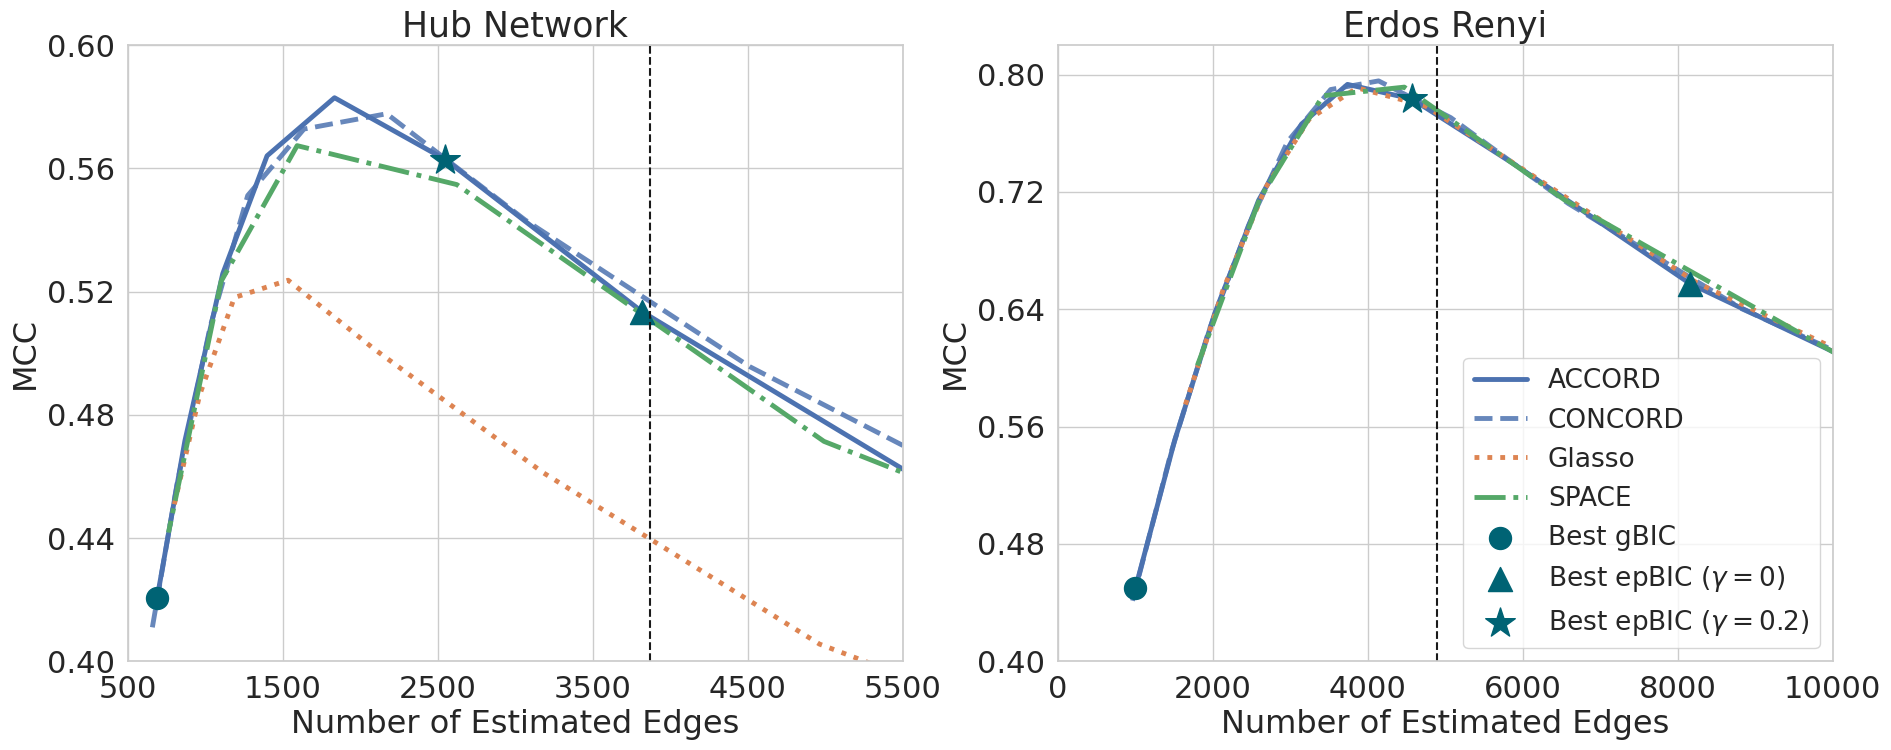

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(accord_edges_hub, accord_mccs_hub, linewidth=3.5, color='C0', label='ACCORD')
axes[i].plot(concord_edges_hub, concord_mccs_hub, linewidth=3.5, linestyle='--', color='C0', alpha=0.85, label='CONCORD')
axes[i].plot(glasso_edges_hub, glasso_mccs_hub, linewidth=3.5, linestyle=':', color='C1', label='Glasso')
axes[i].plot(space_edges_hub, space_mccs_hub, linewidth=3.5, linestyle='-.', color='C2', label='SPACE')
axes[i].scatter(accord_edges_hub[best_gbic_hub], accord_mccs_hub[best_gbic_hub], marker='o', zorder=2, s=250, color=sns.color_palette('dark')[-1], label='Best gBIC')
axes[i].scatter(accord_edges_hub[best_pbic_hub], accord_mccs_hub[best_pbic_hub], marker='^', zorder=2, s=300, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0$)')
axes[i].scatter(accord_edges_hub[best_epbic_hub], accord_mccs_hub[best_epbic_hub], marker='*', zorder=2, s=500, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0.2$)')
axes[i].axvline((len(np.flatnonzero(Theta_hub))-p)/2, linewidth=1.5, color='k', linestyle='--')
axes[i].set_title('Hub Network', fontsize=25)
axes[i].set_xlabel('Number of Estimated Edges', fontsize=23)
axes[i].set_ylabel('MCC', fontsize=23)
axes[i].tick_params(axis='both', which='major', labelsize=22)
axes[i].set_xlim((500,5500))
axes[i].set_ylim((0.4,0.6))
axes[i].set_xticks(np.arange(500, 6000, 1000))
axes[i].set_yticks(np.arange(0.4, 0.61, 0.04))

i = 1
axes[i].plot(accord_edges_er, accord_mccs_er, linewidth=3.5, color='C0', label='ACCORD')
axes[i].plot(concord_edges_er, concord_mccs_er, linewidth=3.5, linestyle='--', color='C0', alpha=0.85, label='CONCORD')
axes[i].plot(glasso_edges_er, glasso_mccs_er, linewidth=3.5, linestyle=':', color='C1', label='Glasso')
axes[i].plot(space_edges_er, space_mccs_er, linewidth=3.5, linestyle='-.', color='C2', label='SPACE')
axes[i].scatter(accord_edges_er[best_gbic_er], accord_mccs_er[best_gbic_er], marker='o', zorder=2, s=250, color=sns.color_palette('dark')[-1], label='Best gBIC')
axes[i].scatter(accord_edges_er[best_pbic_er], accord_mccs_er[best_pbic_er], marker='^', zorder=2, s=300, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0$)')
axes[i].scatter(accord_edges_er[best_epbic_er], accord_mccs_er[best_epbic_er], marker='*', zorder=2, s=500, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0.2$)')
axes[i].axvline((len(np.flatnonzero(Theta_er))-p)/2, linewidth=1.5, color='k', linestyle='--')
axes[i].set_title('Erdos Renyi', fontsize=25)
axes[i].set_xlabel('Number of Estimated Edges', fontsize=23)
axes[i].set_ylabel('MCC', fontsize=23)
axes[i].tick_params(axis='both', which='major', labelsize=22)
axes[i].set_xlim((0,10000))
axes[i].set_ylim((0.4,0.82))
axes[i].set_yticks(np.arange(0.4, 0.81, 0.08))
axes[i].legend(fontsize=19, loc='lower right')

plt.savefig('../output/edge_detection.png', bbox_inches='tight');